# Comparing Classification Performance
We are going to several classification algorithms to the loan data used in previous notebook and we will compare the results. 

As the very first step, we load all the relevant libraries.

In [82]:
# general purpose libraries libraries for tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# models
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# stat libraries
from scipy import stats

# Libraries for the evaluation
from sklearn import model_selection
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

%matplotlib inline

Then, we load the data.

In [2]:
# loans = pd.read_csv('LoansData01.csv')
loans = pd.read_csv('LoansNumerical.csv')

In [3]:
target = 'safe_loans'
features = loans.columns[loans.columns!=target]

The input variables x are the columns corresponding to the features, the output variable y is the column corresponding to the target variable.

In [4]:
x = loans[features]
y = loans[target]

First we apply plain logistic regression without regularization (thus $\alpha$ is zero). The Scikit-learn function does not allow to specify $\alpha$ but it uses a parameter C=1/$\alpha$. Accordingly, to have no regularization we need to specify a huge value of C. And we evaluate the model using plain crossvalidation.

In [5]:
simple_logistic = linear_model.LogisticRegression(C=10e10, random_state=0)
simple_eval = model_selection.cross_val_score(simple_logistic, x, y, cv=10)
print("Simple Logistic Regression\t%4.3f\t%4.3f" % (np.average(simple_eval), np.std(simple_eval)))

Simple Logistic Regression	0.808	0.009


Next we apply naive bayes, nearest centroids, knn, and random forests.

In [7]:
nb = naive_bayes.GaussianNB();
nb_eval = model_selection.cross_val_score(nb, x, y, cv=10)
print("Naive Bayes\t%4.3f\t%4.3f" % (np.average(nb_eval), np.std(nb_eval)))

Naive Bayes	0.770	0.017


In [9]:
knn = neighbors.KNeighborsClassifier(20, weights='distance')
knn_eval = model_selection.cross_val_score(knn, x, y, cv=10)
print("k Nearest Neighbor\t%4.3f\t%4.3f" % (np.average(knn_eval), np.std(knn_eval)))

k Nearest Neighbor	0.801	0.004


In [10]:
rf = RandomForestClassifier(n_estimators=40, max_depth=None, min_samples_split=2, random_state=0)
rf_eval = model_selection.cross_val_score(rf, x, y)
print("Random Forest\t%4.3f\t%4.3f" % (np.average(rf_eval), np.std(rf_eval)))

Random Forest	0.807	0.007


## Comparing Two Models using Unpaired t-test
Although all the models have been evaluated have been evaluated with cross-validation, we don't know whether the folds are the same. Thus for instance we don't know if the first element in the evaluation array was measured on the same fold over all the algorithms. Accordingly, we need to apply unpaired t-Test.

Let's compare the performance of Logistic Regression vs Random Forests.

In [18]:
def PrintSignificance(stat, c):
    if (stat[1]<(1-c)):
        print("The difference is statistically significant (cf %3.2f)"%c)
    else:
        print("The difference is not statistically significant (cf %3.2f)"%c)
        
unpaired_lr_rf = stats.ttest_ind(simple_eval, rf_eval)
print("Logistic Regression vs Random Forests: p-value = %4.3f"%unpaired_lr_rf[1])
PrintSignificance(unpaired_lr_rf, 0.95)
print("\n")

unpaired_lr_nb = stats.ttest_ind(simple_eval, nb_eval)
print("Logistic Regression vs Naive Bayes: p-value = %4.3f"%unpaired_lr_nb[1])
PrintSignificance(unpaired_lr_nb, 0.95)
print("\n")


Logistic Regression vs Random Forests: p-value = 0.823
The difference is not statistically significant (cf 0.95)


Logistic Regression vs Naive Bayes: p-value = 0.000
The difference is statistically significant (cf 0.95)


## Comparing Two Models using Paired t-Test
We compare k-nearest-neighbor and random forests using the same folds.

In [80]:
tf = model_selection.KFold(n_splits=10)

knn_scores = []
rf_scores = []

tf.split(loans)
for train, test in tf.split(loans):
    l = loans.loc[train]
    train_x = l[features]
    train_y = l[target]
    
    l_test = loans.loc[test]
    test_x = l_test[features]
    test_y = l_test[target]
    
    knn = neighbors.KNeighborsClassifier(20, weights='distance')
    knn = knn.fit(train_x, train_y)
    acc_knn = accuracy_score(test_y, knn.predict(test_x))

    rf = RandomForestClassifier(n_estimators=40, max_depth=None, min_samples_split=2, random_state=0)
    rf = rf.fit(train_x, train_y)
    acc_rf = accuracy_score(test_y, rf.predict(test_x))
    
    knn_scores = knn_scores + [acc_knn]
    rf_scores = rf_scores + [acc_rf]
    
print("k Nearest Neighbor\t%4.3f\t%4.3f" % (np.average(knn_scores), np.std(knn_scores)))
print("Random Forest     \t%4.3f\t%4.3f" % (np.average(rf_scores), np.std(rf_scores)))

k Nearest Neighbor	0.803	0.040
Random Forest	0.816	0.037


In [81]:
paired_test = stats.ttest_rel(knn_scores, rf_scores)
print("k-nn vs Random Forests: p-value = %4.3f"%paired_test[1])
PrintSignificance(paired_test, 0.95)

k-nn vs Random Forests: p-value = 0.000
The difference is statistically significant (cf 0.95)


## Receiver Operating Characteristic (ROC) Curves
We now plot the ROC curve for Logistic Regression and Naive Bayes

Logistic Regression	0.811
Naive Bayes        	0.776
Random Forest      	0.818


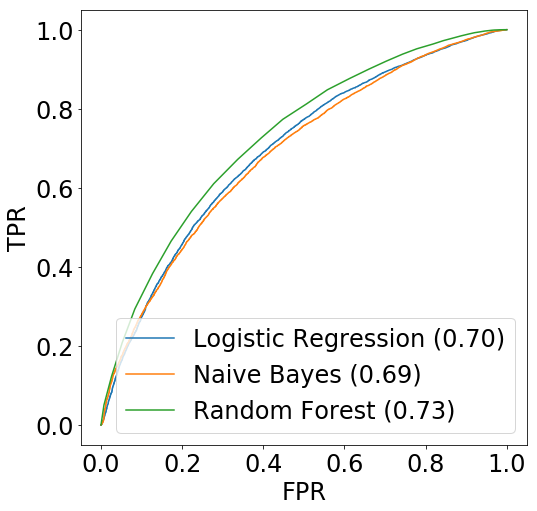

In [95]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y, test_size=0.33, random_state=42)

simple_logistic = linear_model.LogisticRegression(C=10e10, random_state=0)
simple_eval = simple_logistic.fit(train_x, train_y)
lr_pred = simple_logistic.predict(test_x);
lr_acc = accuracy_score(y_true=test_y, y_pred=lr_pred)
print("Logistic Regression\t%4.3f" % lr_acc)

nb = naive_bayes.GaussianNB();
nb_eval = nb.fit(train_x, train_y)
nb_pred = nb.predict(test_x)
nb_acc = accuracy_score(y_true=test_y, y_pred=nb_pred)
print("Naive Bayes        \t%4.3f" % nb_acc)

rf = RandomForestClassifier(n_estimators=40, max_depth=None, min_samples_split=2, random_state=0)
rf_eval = rf.fit(train_x, train_y)
rf_pred = rf.predict(test_x)
rf_acc = accuracy_score(y_true=test_y, y_pred=rf_pred)
print("Random Forest      \t%4.3f" % rf_acc)


lr_prob = simple_eval.predict_proba(test_x)
nb_prob = nb_eval.predict_proba(test_x)
rf_prob = rf_eval.predict_proba(test_x)

fpr, tpr, thresholds = roc_curve(y_true=test_y, y_score = lr_prob[:,1], pos_label=1)
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_true=test_y, y_score = nb_prob[:,1], pos_label=1)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_true=test_y, y_score = rf_prob[:,1], pos_label=1)



lr_roc_auc = roc_auc_score(y_true=test_y, y_score = lr_prob[:,1])
nb_roc_auc = roc_auc_score(y_true=test_y, y_score = nb_prob[:,1])
rf_roc_auc = roc_auc_score(y_true=test_y, y_score = rf_prob[:,1])



plt.figure(1, figsize=(8, 8));
font = {'family':'sans', 'size':24};
plt.rc('font', **font);
plt.xlabel('FPR');
plt.ylabel('TPR');
plt.plot(fpr,tpr,label='Logistic Regression (%3.2f)'%lr_roc_auc)
plt.plot(fpr_nb,tpr_nb,label='Naive Bayes (%3.2f)'%nb_roc_auc)
plt.plot(fpr_rf,tpr_rf,label='Random Forest (%3.2f)'%rf_roc_auc)
plt.yticks(np.arange(0.0,1.01,.2))
plt.legend()
plt.show();

So while accuracy is quite different (almost four percentage points) the AUC for Logistic Regression and Naive Bayes is quite similar. This is not surprising as the two metrics measures different aspects of performance. The ROC curve shows that the two approaches behave similarly when it comes to TPR and FPR. Random forests perform better both as accuracy and AUC.